$\textbf{Propagation Delay Calculation}$

$\text{In this tutorial we will see how to calculate the $t_0$ with the known sample. To ensure accurate estimation you should select your peak within the big mc range. You should also make your calculation for a smal volum spacialy and for a smal varition of voltage. Another pont is that you should chose a narrow window around your peaks.}$

In [1]:
%matplotlib ipympl
import os
import os.path as path
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from ipywidgets import fixed, interact_manual, widgets

# Local module and scripts
from pyccapt.calibration.calibration_tools import variables, tools, data_tools
from pyccapt.calibration.mc import mc_tools
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.calibration_tools import dataset_path_qt


# if you want to save the picture the process takes too long
# For faster run put save_figure to False
save_figure = True

In [2]:
# Disable showing logging in Jupyter notebook
import logging, sys
logging.disable(sys.maxsize)
save_fig=False
plot_fig=True 

In [3]:
button = widgets.Button(
    description='load dataset',
)

@button.on_click
def open_file_on_click(b):
    global dataset_path
    dataset_path = dataset_path_qt.gui_fname().decode('ASCII')
button

Button(description='load dataset', style=ButtonStyle())

In [31]:
tdc, pulse_mode, flightPathLength_d, t0_d, max_tof = wd.dataset_tdc_selection()
display(tdc, pulse_mode, flightPathLength_d, max_tof)

Dropdown(description='TDC model:', options=('surface_concept', 'roentdec'), value='surface_concept')

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

FloatText(value=110.0, description='Flight path length:')

IntText(value=5000, description='Max tof:')

In [60]:
tdc_model = tdc.value
pulse_mode_ini = pulse_mode.value
flightPathLength = flightPathLength_d.value # mm 
max_tof_ini = max_tof.value # ns

dataset_main_path = os.path.dirname(dataset_path)
dataset_name_with_extention = os.path.basename(dataset_path)
dataset_name = os.path.splitext(dataset_name_with_extention)[0]

variables.init()

variables.result_path = dataset_main_path + '/' + dataset_name + '/t0_calibration/'
if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)

filename = dataset_path



head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

data = data_tools.read_hdf5_through_pandas(filename)
        

In [33]:
data

,high_voltage (V),pulse (V),start counter,t (ns),mc (Da),x_det (mm),y_det (mm),pulse_pi,ion_pp
0,3479.0,0.0,0.0,583.519697,27.010796,-0.71,21.95,0,0.0
1,3479.0,0.0,0.0,598.651648,26.968296,17.19,26.85,243,0.0
2,3479.0,0.0,0.0,609.434664,27.980232,16.89,26.81,3,0.0
3,3479.0,0.0,0.0,599.775672,26.965658,16.54,28.04,178,0.0
4,3479.0,0.0,0.0,600.066662,27.205231,15.76,26.92,525,0.0
...,...,...,...,...,...,...,...,...,...
20745666,4757.5,0.0,0.0,491.954684,27.023506,14.15,7.56,323,0.0
20745667,4757.5,0.0,0.0,492.891699,27.004519,2.47,17.32,59,0.0
20745668,4757.5,0.0,0.0,506.176651,27.265175,21.39,-15.83,388,0.0
20745669,4757.5,0.0,0.0,511.615694,27.636927,-13.70,-24.92,316,0.0


In [34]:
# exctract needed data from Pandas data frame as an numpy array
dld_highVoltage = data['high_voltage (V)'].to_numpy()
if pulse_mode_ini == 'voltage':
    dld_pulseVoltage = data['pulse (V)'].to_numpy()
elif pulse_mode_ini == 'laser':
    dld_pulseVoltage = data['pulse (deg)'].to_numpy()
dld_t = data['t (ns)'].to_numpy()
dld_x = data['x_det (cm)'].to_numpy()
dld_y = data['y_det (cm)'].to_numpy()
# copy dld_t to a have a global version of that
variables.dld_t_calib = np.copy(dld_t)
mc_seb = mc_tools.tof2mc(dld_t, 0, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength, mode=pulse_mode_ini)
variables.mc_calib = np.copy(mc_seb)

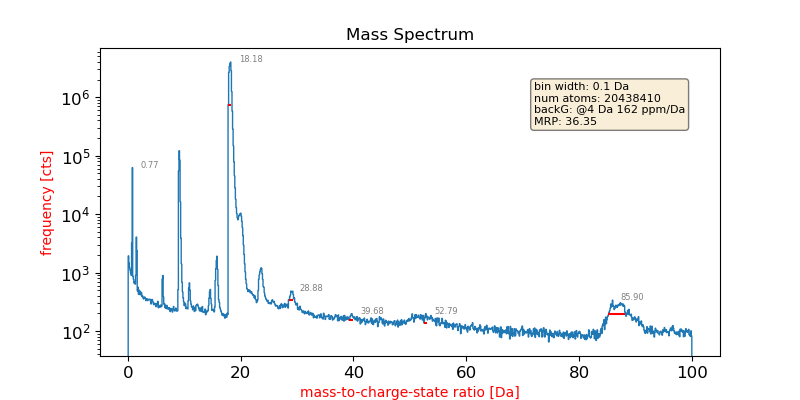

In [35]:
peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(mc_seb[mc_seb < 100], 0.1, prominence=50, distance=100, h_line=True, text_loc='right', percent=50, plot=True, fig_name=figname)

In [36]:
def tof_his(bin_size, prominence, distance, percent, selector, plot, figname, lim_dld_t):
    variables.peaks_idx = []
    global peak_widths
    global peaks_y
    global peaks
    peaks, peaks_y, peak_widths = tools.hist_plot(variables.mc_calib [variables.mc_calib  < lim_dld_t], bin_size,  h_line=True, distance=distance, percent=percent, prominence=prominence, selector=selector, plot=plot, label='mc', fig_name=figname)

    index_max_ini = np.argmax(peaks_y)
    variables.max_peak = peaks[index_max_ini]
    variables.peak = peaks_ini
    mrp = (peaks[index_max_ini] / (peak_widths[index_max_ini][2] - peak_widths[index_max_ini][1]))
    print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
    for i in range(len(peaks)):
        print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks[i], peaks_y[i]), 'peak window sides (half-maximum) are: ({:.2f}, {:.2f})'.format(peak_widths[i][1], peak_widths[i][2]))

$\mathbf{\text{calculate the mc in two mode for laser and voltage atom probe:}}$<br><br>
$$\frac{m}{n} = k V_{dc}(\frac{t + t_{0}}{d})^{2} ,$$<br>
$\text{or:}$
$$\frac{m}{n} = k\alpha (V_{dc} + \beta V_{pulse})(\frac{t + t_{0}}{d})^{2} $$<br>

In [37]:

interact_manual(tof_his, bin_size=widgets.FloatText(value=0.1)
               ,prominence=widgets.IntText(value=50), distance=widgets.IntText(value=10), lim_dld_t=widgets.IntText(value=150)
               ,percent=widgets.IntText(value=80), selector=[('peak','peak'), ('rect', 'rect')], plot=fixed(True), figname=fixed(figname));


interactive(children=(FloatText(value=0.1, description='bin_size'), IntText(value=50, description='prominence'…

$\text{In the cell below you should type the correct m/c for the detected peak above}$

In [39]:
# The correct peak location based on your sample
peak_ideal = [1.01, 13.49, 26.98]

$\text{Here for each peak a mask will be created}$

In [40]:
pick_ions_plot = []
mask = np.zeros(len(mc_seb), dtype=bool)
mc_seb_ideal = np.zeros(len(mc_seb))
# creat mask for each peak base on the peak loc. and window size
for i in range(len(variables.peaks_idx)):
    print(peak_widths[variables.peaks_idx[i]][1], peak_widths[variables.peaks_idx[i]][2])
    mask_tmp = np.logical_and((peak_widths[variables.peaks_idx[i]][1] < mc_seb), (mc_seb < peak_widths[variables.peaks_idx[i]][2]))
    print(i, len(mask_tmp[mask_tmp==True]))
    
    mask = np.logical_or(mask, mask_tmp)
    mc_seb_ideal[mask_tmp==True] = peak_ideal[i]
    bb = np.zeros(len(mc_seb))
    
    pick_ions_plot.append(mask_tmp)


0.6730518237290393 0.7730789569537734
0 3225
8.875276748157242 9.175358147831444
1 176693
17.777691605158584 18.377854404506987
2 17340245


$\text{The selcted peak ions in shown below}$

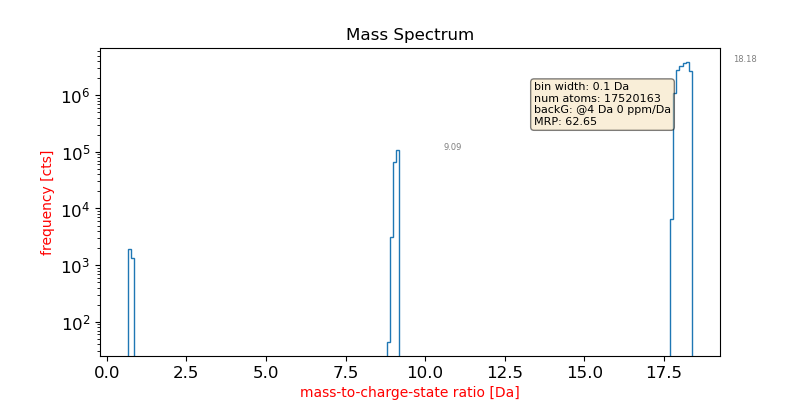

(array([ 9.0901012 , 18.18435954]),
 array([ 107251., 3851291.]),
 [[3090.0, 8.896606338932118, 9.0901011973912],
  [2733562.0, 17.8941172572794, 18.184359544968025]])

In [41]:
mc_seb_masked = mc_seb[mask]
tools.hist_plot(mc_seb_masked[mc_seb_masked < 100], 0.1, peaks_find=True, plot=True)

$\text{Plot ideal peak m/c:}$

d:\pyccapt\pyccapt\calibration\calibration_tools\tools.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots(figsize=(8, 4))


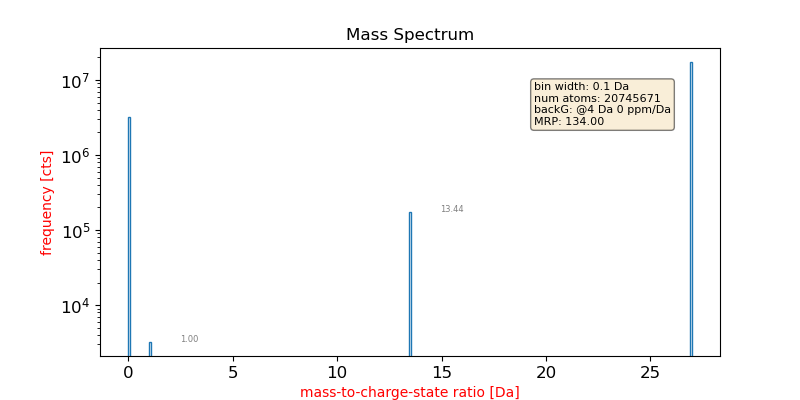

(array([ 1.00297398, 13.4398513 ]),
 array([  3225., 176693.]),
 [[0.0, 0.9026765799256505, 1.0029739776951672],
  [0.0, 13.339553903345724, 13.43985130111524]])

In [42]:
tools.hist_plot(mc_seb_ideal, 0.1, peaks_find=True, plot=True)

$\text{Here we plot ions in each peak base on the TOF and (x,y) position}$

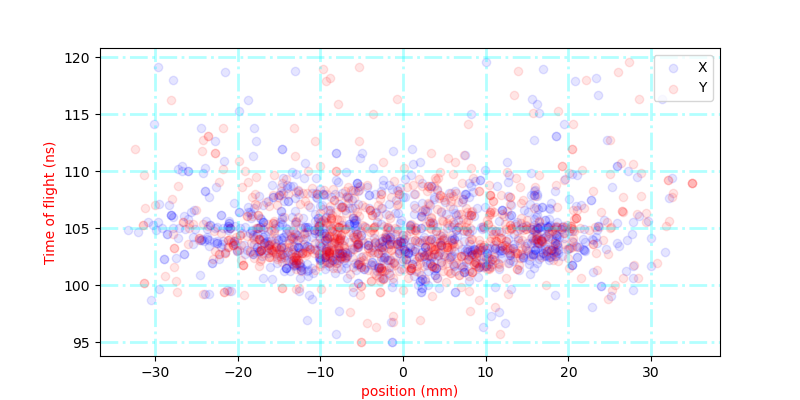

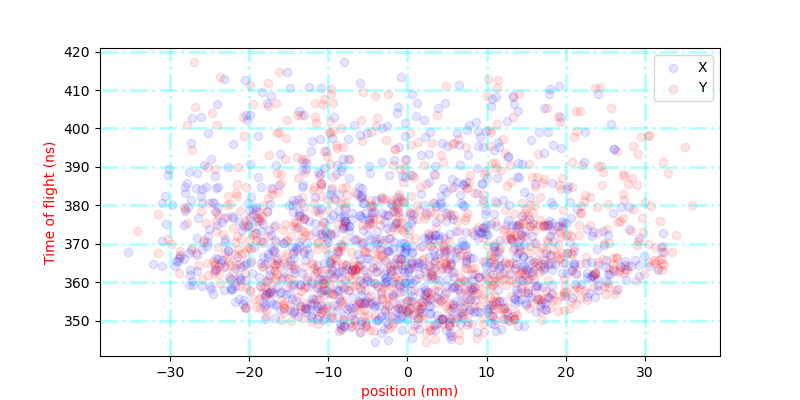

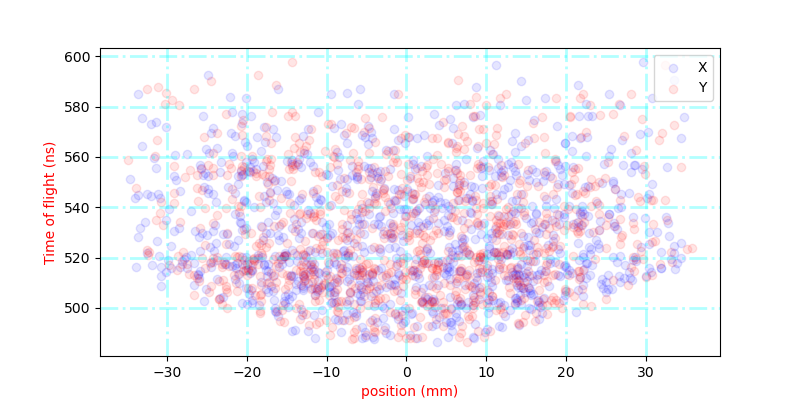

In [43]:
for i in range(len(pick_ions_plot)):
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    dld_x_masked = dld_x[pick_ions_plot[i]]
    dld_y_masked = dld_y[pick_ions_plot[i]]
    dld_t_masked = dld_t[pick_ions_plot[i]]
    if len(dld_x_masked) > 1000:
        mask_plot = np.random.randint(0, len(dld_x_masked), 1000)
        x = plt.scatter(dld_x_masked[mask_plot], dld_t_masked[mask_plot], color="blue", label='X', alpha=0.1)
        y = plt.scatter(dld_y_masked[mask_plot], dld_t_masked[mask_plot], color="red", label='Y', alpha=0.1)
    else:
        x = plt.scatter(dld_x_masked, dld_t_masked, color="blue", label='X', alpha=0.1)
        y = plt.scatter(dld_y_masked, dld_t_masked, color="red", label='Y', alpha=0.1)
    ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
    ax1.set_xlabel("position (cm)", color="red", fontsize=10)
    plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
    plt.legend(handles=[x, y], loc='upper right')
    if save_figure == True:
        plt.savefig(variables.result_path + 'position_peak_%s' %i + "%s.png" %figname, format="png", dpi=600)
    plt.show()

$\text{As you saw the TOF changes base on the (x,y) of the events. Therefore we creat a mask to only select the ions in center (8m
m*8mm) of detector. This helps to cansel out the variation in TOF due to hit position}$

$\text{Reformulate the equation for volatege atom probe:}$<br>
$$t = d(\sqrt{\frac{\frac{m}{n}}{k\alpha (V_{dc}+\beta V_{pulse})}})-t_{0} $$<br>

(82609,)


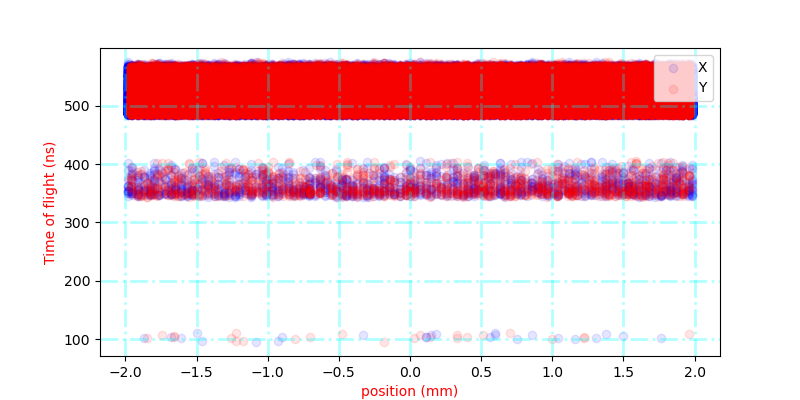

In [47]:
# use mask_equal to have equal number of ions for each peak
# only peak the value in the center of detector 8mm * 8mm
detector_squre = 0.8
fig1, ax1 = plt.subplots(figsize=(8, 4))
dld_x_masked = dld_x[mask]
dld_y_masked = dld_y[mask]
dld_t_masked = dld_t[mask]
dld_highVoltage_masked = dld_highVoltage[mask]

mask_tmp_middle = np.logical_and((np.abs(dld_x_masked) < detector_squre), (np.abs(dld_y_masked) < detector_squre))
dld_x_masked = dld_x_masked[mask_tmp_middle]
dld_y_masked = dld_y_masked[mask_tmp_middle]
dld_t_masked = dld_t_masked[mask_tmp_middle]
dld_highVoltage_masked = dld_highVoltage_masked[mask_tmp_middle]

mc_seb_reg_masked = mc_seb_ideal[mask]
mc_seb_reg_masked = mc_seb_reg_masked[mask_tmp_middle]

print(dld_t_masked.shape)
x = plt.scatter(dld_x_masked, dld_t_masked, color="blue", label='X', alpha=0.1)
y = plt.scatter(dld_y_masked, dld_t_masked, color="red", label='Y', alpha=0.1)
ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
ax1.set_xlabel("position (cm)", color="red", fontsize=10)
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
plt.legend(handles=[x, y], loc='upper right')
if save_figure == True:
    plt.savefig(variables.result_path + 'center_' + "%s.png" %figname, format="png", dpi=600)
#     plt.savefig(variables.result_path + '/center_' + "%s.svg" %figname, format="svg", dpi=600)
plt.show()


$\text{We calculate the t_0 base on:}$<br>
$$t_{0} = \frac{\sum_{n=1}^n{\left (t - L_{flight}  \sqrt{\frac{m/n}{2eV}} \right )}}{n}$$<br>

In [61]:
seb_t = dld_t_masked * 1E-9  # tof in s
# seb_factor = np.sqrt(mc_seb_reg_ideal[mask_middle] * 1.66E-27 / (2 * 1.6E-19 * 1.015 * (dld_highVoltage_masked + 0.7 * dld_pulseVoltage_masked)))
seb_factor = np.sqrt(mc_seb_reg_masked * 1.66E-27 / (2 * 1.6E-19 * dld_highVoltage_masked))

seb_factor = seb_factor * 1E6
seb_t = seb_t * 1E9

t0_seb_fixed = np.mean(np.array([seb_t]).squeeze(0) - (flightPathLength * np.array([seb_factor]).squeeze(0).reshape(-1, 1)))
print('Linear fixed path lenght -- the flight path lenght(slop): {:.2f}'.format(flightPathLength), '(mm)', '\nthe corrected t_0(intercept): {:.2f}'.format(t0_seb_fixed), '(ns)')


Linear fixed path lenght -- the flight path lenght(slop): 90.00 (mm) 
the corrected t_0(intercept): -2.02 (ns)


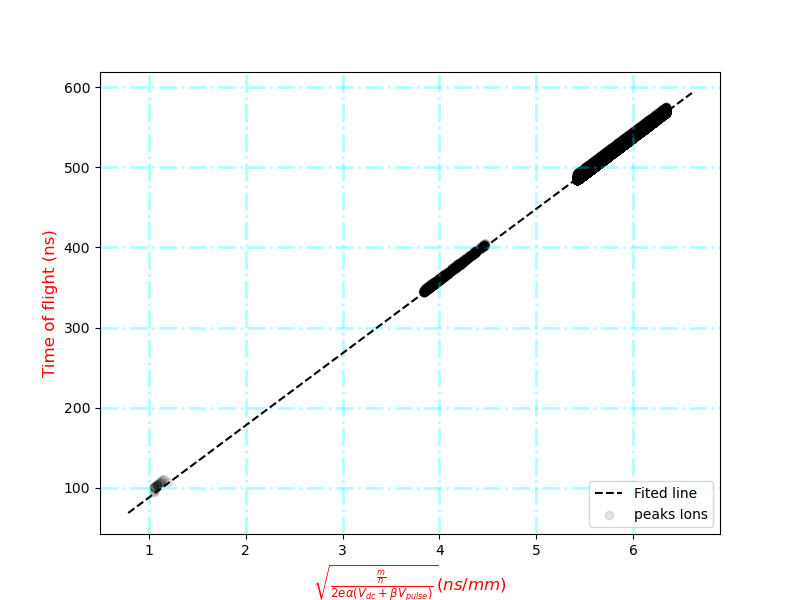

In [69]:
# Plot outputs
fig1, ax1 = plt.subplots(figsize=(8, 6))
peaks_data = plt.scatter(seb_factor, seb_t, color="black", label='peaks Ions', alpha=0.1)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())

linear_fix, = plt.plot(x_vals, t0_seb_fixed + flightPathLength * x_vals, '--', color='black', label='Fited line' )

plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
plt.legend(handles=[linear_fix, peaks_data], loc='lower right')

ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=12)

ax1.set_xlabel(r"$\sqrt{\frac{\frac{m}{n}}{2e \alpha (V_{dc} + \beta V_{pulse})}} (ns/mm)$", color="red", fontsize=12)
if save_figure == True:
    plt.savefig(variables.result_path + 'fixed_flight_path' + "%s.svg" %figname, format="svg", dpi=600)
    plt.savefig(variables.result_path + 'fixed_flight_path' + "%s.png" %figname, format="png", dpi=600)
plt.show()

In [63]:
huber = linear_model.HuberRegressor(alpha=1E-9,epsilon=1)
huber.fit(np.array([seb_factor]).squeeze(0).reshape(-1, 1), np.array([seb_t]).squeeze(0))
d_seb_huber = huber.coef_.item()
t0_seb_huber = huber.intercept_.item()          
print('Huber -- 2 the corrected flight path lenght(slop): {:.2f}'.format(d_seb_huber), '(mm)', '\nthe corrected t_0(intercept): {:.2f}'.format(t0_seb_huber), '(ns)')

bayesian_ridge = linear_model.Ridge(alpha=1)
bayesian_ridge.fit(np.array([seb_factor]).squeeze(0).reshape(-1, 1) , np.array([seb_t]).squeeze(0))
d_seb_rigid = bayesian_ridge.coef_.item()
t0_seb_rigid = bayesian_ridge.intercept_.item()         
print('Rigid -- the corrected flight path lenght(slop): {:.2f}'.format(d_seb_rigid), '(mm)', '\nthe corrected t_0(intercept): {:.2f}'.format(t0_seb_rigid), '(ns)')
# Train the model using the data sets ( linear regression)
linear = linear_model.LinearRegression()
linear.fit(np.array([seb_factor]).squeeze(0).reshape(-1, 1), np.array([seb_t]).squeeze(0))
d_seb = linear.coef_.item()
t0_seb = linear.intercept_.item()

print('Linear -- the corrected flight path lenght(slop): {:.2f}'.format(d_seb), '(mm)', '\nthe corrected t_0(intercept): {:.2f}'.format(t0_seb), '(ns)')
# Train the model using the data sets ( Lasso regression)
lasso = linear_model.Lasso(alpha=1)
lasso.fit(np.array([seb_factor]).squeeze(0).reshape(-1, 1), np.array([seb_t]).squeeze(0))
d_seb_lasso = lasso.coef_.item()
t0_seb_lasso = lasso.intercept_.item() 
print('Lasso -- the corrected flight path lenght(slop): {:.2f}'.format(d_seb_lasso), '(mm)', '\nthe corrected t_0(intercept): {:.2f}'.format(t0_seb_lasso), '(ns)')


Huber -- 2 the corrected flight path lenght(slop): 90.68 (mm) 
the corrected t_0(intercept): -6.52 (ns)
Rigid -- the corrected flight path lenght(slop): 90.15 (mm) 
the corrected t_0(intercept): -2.88 (ns)
Linear -- the corrected flight path lenght(slop): 90.16 (mm) 
the corrected t_0(intercept): -2.93 (ns)
Lasso -- the corrected flight path lenght(slop): 81.98 (mm) 
the corrected t_0(intercept): 44.04 (ns)


In [65]:
variables.result_path

'D:/pyccapt/tests/data/Bicrys_version5_Al_1_12_22_francois_V6_our_structure/t0_calibration/'

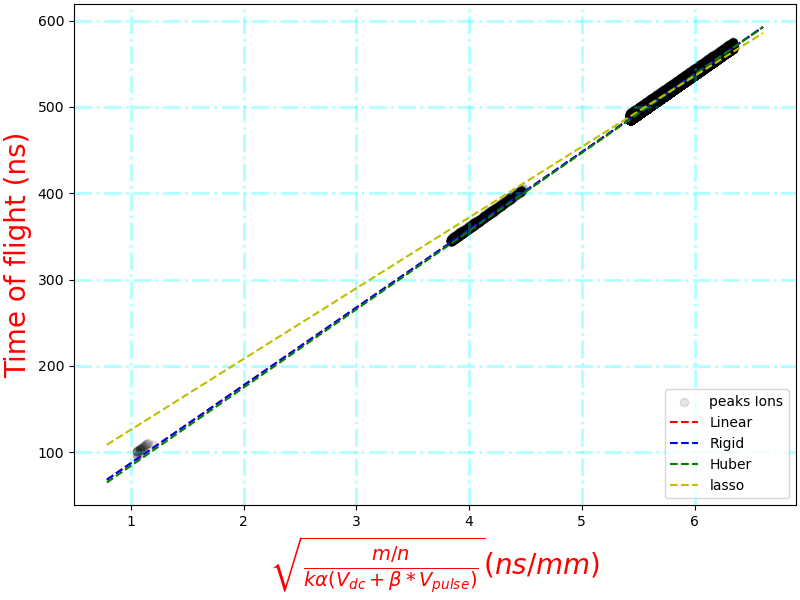

In [68]:
# Plot outputs
fig1, ax1 = plt.subplots(figsize=(8, 6), constrained_layout=True)
peaks_data = plt.scatter(seb_factor, seb_t, color="black", label='peaks Ions', alpha=0.1)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())


linear, = plt.plot(x_vals, t0_seb + d_seb * x_vals, '--', color='r', label='Linear' )
rigid, = plt.plot(x_vals, t0_seb_rigid + d_seb_rigid * x_vals, '--', color='b', label='Rigid' )
huber, = plt.plot(x_vals, t0_seb_huber + d_seb_huber * x_vals, '--', color='g', label='Huber' )
lasso, = plt.plot(x_vals, t0_seb_lasso + d_seb_lasso * x_vals, '--', color='y', label='lasso' )

plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)

plt.legend(handles=[peaks_data, linear, rigid, huber,lasso], loc='lower right')
ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=20)
ax1.set_xlabel(r"$\sqrt{\frac{m/n}{k\alpha(V_{dc}+\beta*V_{pulse} )}} (ns/mm)$", color="red", fontsize=20)

if save_figure == True:
    plt.savefig(variables.result_path + 'regression' + "%s.png" %figname, format="png", dpi=600)

plt.show()

In [52]:
t0_new = t0_seb
flightPathLength_new = d_seb

$\text{Plot the m/c with new ${t_0}$ :}$<br>

In [53]:
# calculate the mc with new flight path lenght and t_0
mc_seb = mc_tools.tof2mc(dld_t, t0_new, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength_new)
variables.mc_calib = mc_seb
interact_manual(tof_his, bin_size=widgets.FloatText(value=0.1)
               ,prominence=widgets.IntText(value=50), distance=widgets.IntText(value=10), lim_dld_t=widgets.IntText(value=150)
               ,percent=widgets.IntText(value=5), selector=[('peak','peak'), ('rect', 'rect')], plot=fixed(True), figname=fixed(figname));


interactive(children=(FloatText(value=0.1, description='bin_size'), IntText(value=50, description='prominence'…